# Проект: поиск по изображениям

## Описание проекта, цели, задачи

Пользователи фотохостинга для профессиональных фотографов размещают свои фотографии и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

**Задача проекта** заключается в следующем: разработать модель, которая по описанию сцены подбирает изображения. Например, под описание: "A man is crossing a mountain pass on a metal bridge" модель должна подобрать следующее изображние:

<center>
    <img src="https://pictures.s3.yandex.net/resources/551403320_dfdcf9fc3b_1661350763.jpg">
</center>
<center>
    <font size = "5">A man is crossing a mountain pass on a metal bridge</font>
</center>

**В качестве демонстрационной версии (MVP)** нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

**Описание данных**

В качестве исходных данных предоставлены:
1. 1000 фотографий для обучения модели в папке **train-images**;
1. 100 фотографий для тестирования и демонстрации возможностей модели в папке **test-images**;
1. файл **train_dataset.csv** содержит информацию, необходимую для обучения: имя файла изображения, идентификатор описания и текст описания, для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`;
1. в файле **CrowdAnnotations.tsv**  содержатся данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
    * Имя файла изображения;
    * Идентификатор описания;
    * Доля людей, подтвердивших, что описание соответствует изображению;
    * Количество человек, подтвердивших, что описание соответствует изображению;
    * Количество человек, подтвердивших, что описание не соответствует изображению.
1. в файле **ExpertAnnotations.tsv** хранятся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
    * Имя файла изображения;
    * Идентификатор описания;
    * 3, 4, 5 — оценки трёх экспертов.
1. В файле **test_queries.csv** находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. *Для одной картинки может быть доступно до 5 описаний.* Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

**Примечание:** Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.    

## Юридические ограничения

В некоторых странах, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

При попытке посмотреть изображения, запрещённые законодательством, вместо картинок должен показывается дисклеймер: **This image is unavailable in your country in compliance with local laws**. Необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

## Краткое описание предложенного решения

В результате проведенного исследования, была разработана **основная функция search_image, которая объединяет в себе весь процесс поиска и верификации изображений:** получает векторное представление текста, векторные представления изображений из базы, рассчитывает для каждой пары метрику на основе косинусного расстояния от 0 до 1, которая показывает, насколько текст и картинка подходят друг другу и отбирает lim лучших изображений, подходящих по строке запроса:
* текстовые запросы из тренировочного набора векторизованы с помощью стандартной модели BERT, размер эмбеддинга на выходе - 768;
* изображения из тренировочного набора с помощью сверточной нейронной сети ResNet50, размер эмбеддинга на выходе - 2048;
* на вход модель получает векторизованный эмбеддинг текстового запроса с размерностью 768;
* переводит его в некоторое приближенное подобие векторизованного эмбеддинга изображения, которое такому запросу должно соответствовать, с размерностью 2048.

Для работы функции необходима обученная модель, в качестве которой была выбрана нейронная сеть с несколькими полносвязными слоями и несколькими слоями регуляризации Dropout. Чтобы научить модель выполнять такие вычисления (преобразования), были отобраны пары описание-изображение, в которых изображение полностью или частично подходит описанию, опираясь на комплексную оценку - если оценка выше 0.5, значит описание больше подходит, чем нет. Комплексная оценка была рассчитана по следующей формуле:

$$\frac{W_e*R_e*C_e + R_c*C_c}{W_e*C_e - C_c}$$

где $W_e$ - вес экспертных оценок (примем равынм 2), $R_e$ - сводная оценка экспертов в диапазоне от 0 до 1, $C_e$ - количество экспертов, задействованых для оценки (всегда равно 3), $R_c$ - сводная оценка "толпы", $C_c$ - количество человек, задействованых для оценки (от 3 до 6).

Исходя из полученных результатов можно считать, что концепция показала свою жизнеспособность и может быть доработана с помощью увеличения датасета и построения более глубокой нейросети с более тщательным подбором гирперпараметров, возможно рассмотреть ансамбль моделей (нейронная сеть + Ridge), чтобы объединить их лучшие стороны.

In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import seaborn as sns
import re
import os.path
import warnings
import random
from PIL import Image

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import torch
import transformers

import tensorflow as tf
from tensorflow.keras.applications.resnet import (
    ResNet50,
    decode_predictions,
    preprocess_input,
)
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import joblib
from tqdm import tqdm, notebook

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
DATA_DIR = '/kaggle/input/'
OUTPUT_DIR = '/kaggle/working/'

DATASET_DIR = DATA_DIR + 'project-data/' if os.path.exists(DATA_DIR + 'project-data/') else DATA_DIR
TRAIN_IMG_DIR = DATA_DIR + 'train-images/' if os.path.exists(DATA_DIR + 'train-images/') else DATA_DIR + 'train_images/'
TEST_IMG_DIR = DATA_DIR + 'test-images/' if os.path.exists(DATA_DIR + 'test-images/') else DATA_DIR + 'test_images/'

RECNT_NBOOK = False
RANDOM_SEED = 12345

tqdm.pandas()

In [3]:
nltk.download('stopwords', OUTPUT_DIR)
nltk.download('wordnet', OUTPUT_DIR)
nltk.download('omw-1.4', OUTPUT_DIR)
nltk.data.path.append(OUTPUT_DIR)
stop_words = stopwords.words('english')

!unzip -u /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora/

[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /kaggle/working/...
[nltk_data]   Package omw-1.4 is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


## Загрузка и обзор данных

### Обучающий набор данных

In [4]:
for dirname, _, filenames in os.walk(DATA_DIR):
    if len(filenames) > 0:
        print(f'В папке {dirname} обнаружено {len(filenames)} файлов')

В папке /kaggle/input/train-images обнаружено 1000 файлов
В папке /kaggle/input/project-data обнаружено 5 файлов
В папке /kaggle/input/test-images обнаружено 100 файлов


In [5]:
train_dataset = pd.read_csv(DATASET_DIR + 'train_dataset.csv')
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
display(train_dataset.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [7]:
train_dataset.describe().T

count unique                                                top  \
image       5822   1000                          3364151356_eecd07a23e.jpg   
query_id    5822    977                        2600867924_cd502fc911.jpg#2   
query_text  5822    977  Two dogs , one brown and white and one black a...   

           freq  
image        10  
query_id     34  
query_text   34

Согласно условий проекта - одному изображению могут соответствовать до 5-ти правильных описаний (запросов), из сводки по train_dataset видно, что описаний более чем в 5 раз больше, чем уникальных фотографий, однако уникальных описаний практически 1:1 с уникальными фото, это означает, что пары описание:фото перемешаны. Однако, можно предположить, что описания одних фотографий могут также подходить и к другим и степень похожести могут определеить оценки экспертов.

In [8]:
crowd_annotations = pd.read_csv(DATASET_DIR + 'CrowdAnnotations.tsv',
                                sep = '\t',
                                header = None,
                                names = ['image', 'query_id', 'pos_ratio', 'pos', 'neg']
                               )
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   pos_ratio  47830 non-null  float64
 3   pos        47830 non-null  int64  
 4   neg        47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [9]:
display(crowd_annotations.head())

image                     query_id  pos_ratio  pos  neg
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0    3    0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0    0    3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0    0    3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0    0    3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0    0    3

In [10]:
crowd_annotations.describe(include = 'all').T

count unique                         top freq      mean  \
image        47830   1000   1572532018_64c030c974.jpg  120       NaN   
query_id     47830   1000  249394748_2e4acfbbb5.jpg#2  169       NaN   
pos_ratio  47830.0    NaN                         NaN  NaN  0.068786   
pos        47830.0    NaN                         NaN  NaN  0.208488   
neg        47830.0    NaN                         NaN  NaN  2.820155   

                std  min  25%  50%  75%  max  
image           NaN  NaN  NaN  NaN  NaN  NaN  
query_id        NaN  NaN  NaN  NaN  NaN  NaN  
pos_ratio  0.207532  0.0  0.0  0.0  0.0  1.0  
pos        0.628898  0.0  0.0  0.0  0.0  5.0  
neg        0.656676  0.0  3.0  3.0  3.0  6.0

In [11]:
print(f"Полных дубликатов - {crowd_annotations.duplicated().sum()}, \
дубликатов пар фото:описание - {crowd_annotations.duplicated(subset = ['image', 'query_id']).sum()}")

Полных дубликатов - 0, дубликатов пар фото:описание - 0


Здесь пар фото:описание ещё больше, дубликатов не обнаружено, некторые описания встречаются по 169 раз!

In [12]:
expert_annotations = pd.read_csv(DATASET_DIR + 'ExpertAnnotations.tsv',
                                sep = '\t',
                                header = None,
                                names = ['image', 'query_id', 'exp_1', 'exp_2', 'exp_3']
                               )
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [13]:
display(expert_annotations.head())

image                     query_id  exp_1  exp_2  exp_3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1      2

In [14]:
expert_annotations.describe(include = 'all').T

count unique                          top freq      mean       std  \
image       5822   1000    3107513635_fe8a21f148.jpg   10       NaN       NaN   
query_id    5822    977  2600867924_cd502fc911.jpg#2   34       NaN       NaN   
exp_1     5822.0    NaN                          NaN  NaN   1.43662  0.787084   
exp_2     5822.0    NaN                          NaN  NaN  1.624356  0.856222   
exp_3     5822.0    NaN                          NaN  NaN  1.881999  0.904087   

          min  25%  50%  75%  max  
image     NaN  NaN  NaN  NaN  NaN  
query_id  NaN  NaN  NaN  NaN  NaN  
exp_1     1.0  1.0  1.0  2.0  4.0  
exp_2     1.0  1.0  1.0  2.0  4.0  
exp_3     1.0  1.0  2.0  2.0  4.0

Экспертные оценки вероятно выполнялись по тренировочному набору - количество фотографий и пар фото:описание совпадают.

### Тестовый набор данных

In [15]:
test_images = pd.read_csv(DATASET_DIR + 'test_images.csv')
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [16]:
display(test_images.head())

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [17]:
test_images.nunique()

image    100
dtype: int64

In [18]:
test_queries = pd.read_csv(DATASET_DIR + 'test_queries.csv', sep = '|', index_col = 0)
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [19]:
display(test_queries.head())

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [20]:
display(test_queries.describe(include = 'all').T)

count unique                                                top  \
query_id     500    500                        1177994172_10d143cb8d.jpg#0   
query_text   500    500  Two blonde boys , one in a camouflage shirt an...   
image        500    100                          1177994172_10d143cb8d.jpg   

           freq  
query_id      1  
query_text    1  
image         5

**Выводы:**
1. В качестве исходных данных были загружены: 1000 фотографий для обучения модели, 100 фотографий для тестирования и демонстрации возможностей модели, данные по соответствию изображения и описания, полученные с помощью краудсорсинга и в результате опроса экспертов;
1. Данные не содержат пропусков, не содержат дубликатов;
1. Согласно условий проекта - одному изображению могут соответствовать до 5-ти правильных описаний (запросов), из сводки по train_dataset видно, что описаний более чем в 5 раз больше, чем уникальных фотографий, однако уникальных описаний практически 1:1 с уникальными фото, это означает, что пары описание:фото перемешаны;
1. Предположительно описания одних фотографий могут также подходить и к другим и степень похожести могут определеить оценки полученные с помощью экспертов и краудсорсинга.

## Исследовательский анализ данных (EDA)

В данном разделе:
* исследуем, насколько качественно размечают данные эксперты и "толпа" (краудсорсинг);
* приведем оценки экспертов к единой оценке;
* спроектируем комплексную оценку экспертов и толпы.

### Тренировочный набор данных

Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`, выделим из него название фотографии, к которой оно составлено и сопоставим с названием фотографии, к которой оно прикреплено:

In [21]:
train_dataset['accordance'] = train_dataset.apply(lambda x: True if x['image'] == x['query_id'][:-2] else False, axis = 1)

In [22]:
train_dataset['accordance'].value_counts()

False    5664
True      158
Name: accordance, dtype: int64

Получается, что всего 158 фотографий в тренировочном наборе имеют описание, которое составлено для них, если мы будем обучать модель всего на 158 объектах - ничего не выйдет, слишком маленькая выборка. Далее рассмотрим, насколько качественно размечают данные эксперты и "толпа" (краудсорсинг):

### Экспертные оценки

In [23]:
expert_annotations['accordance'] = expert_annotations.apply(lambda x: True if x['image'] == x['query_id'][:-2] else False, axis = 1)

In [24]:
expert_annotations.head(3)

image                     query_id  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   

   exp_3  accordance  
0      1       False  
1      2       False  
2      2       False

In [25]:
expert_annotations['accordance'].value_counts()

False    5664
True      158
Name: accordance, dtype: int64

Аналогично тренировочному набору данных всего 158 фотографий имеют описание, которое составлено для них рассмотрим, насколько качественно размечают данные эксперты, какие оценки они ставят фотографиям с подходящим описанием, а какие соответственно остальным:

In [26]:
expert_annotations.loc[expert_annotations['accordance'] == True].describe()

exp_1       exp_2  exp_3
count  158.000000  158.000000  158.0
mean     3.898734    3.987342    4.0
std      0.360288    0.112150    0.0
min      1.000000    3.000000    4.0
25%      4.000000    4.000000    4.0
50%      4.000000    4.000000    4.0
75%      4.000000    4.000000    4.0
max      4.000000    4.000000    4.0

In [27]:
expert_annotations.loc[expert_annotations['accordance'] == False].describe()

exp_1        exp_2        exp_3
count  5664.000000  5664.000000  5664.000000
mean      1.367938     1.558439     1.822917
std       0.677743     0.770122     0.843521
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000

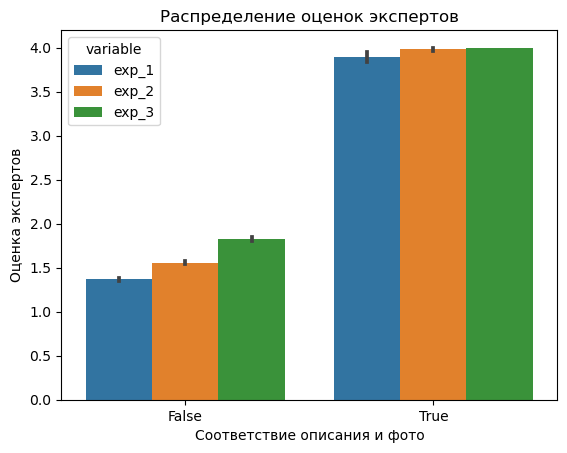

In [28]:
ax = sns.barplot(data = expert_annotations[['exp_1', 'exp_2', 'exp_3', 'accordance']].melt(id_vars = ['accordance'],
                                                                                      value_vars = ['exp_1', 'exp_2', 'exp_3']),
            y = 'value',
            x = 'accordance',
            hue = 'variable'
           )
plt.xlabel('Соответствие описания и фото')
plt.ylabel('Оценка экспертов')
plt.title('Распределение оценок экспертов')
plt.show()

Картина следующая:
* фотографиям с подходящим описанием эксперты в более чем 75% случаев ставят высшую оценку - 4;
* фотографиям, которым сопоставлено описание от других фотографий эксперты ставят низшую оценку - 1 и только в 75% случаев - 2 и выше (иногда 4).

Далее, чтобы объединить оценки экспертов и привести их к диапазону от 0 до 1, выполним обычное min/max шкалирование:

<center>
    <img src="https://i2.wp.com/miro.medium.com/0*QOI2w_HtpqOGn-XP.png">
</center>

In [29]:
expert_annotations['exp_ratio'] = expert_annotations.apply(lambda x: (x['exp_1'] + x['exp_2'] + x['exp_3'] - 3) / 9, axis = 1)
expert_annotations.head()

image                     query_id  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  accordance  exp_ratio  
0      1       False   0.000000  
1      2       False   0.111111  
2      2       False   0.111111  
3      2       False   0.222222  
4      2       False   0.111111

In [30]:
expert_annotations.describe().T

count      mean       std  min  25%       50%       75%  max
exp_1      5822.0  1.436620  0.787084  1.0  1.0  1.000000  2.000000  4.0
exp_2      5822.0  1.624356  0.856222  1.0  1.0  1.000000  2.000000  4.0
exp_3      5822.0  1.881999  0.904087  1.0  1.0  2.000000  2.000000  4.0
exp_ratio  5822.0  0.215886  0.268735  0.0  0.0  0.111111  0.333333  1.0

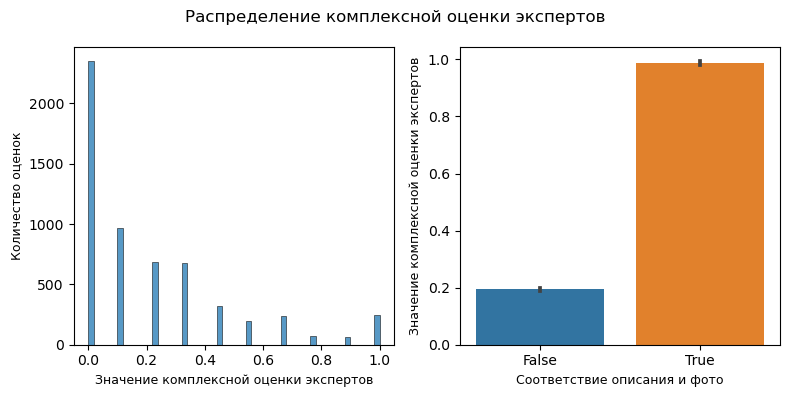

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
sns.histplot(data = expert_annotations['exp_ratio'], bins = 50, ax = ax[0])
ax[0].set_xlabel('Значение комплексной оценки экспертов', fontsize = 9)
ax[0].set_ylabel('Количество оценок', fontsize = 9)
sns.barplot(data = expert_annotations, x = 'accordance', y = 'exp_ratio', ax = ax[1])
ax[1].set_xlabel('Соответствие описания и фото', fontsize = 9)
ax[1].set_ylabel('Значение комплексной оценки экспертов', fontsize = 9)
plt.suptitle('Распределение комплексной оценки экспертов', fontsize = 12)
plt.tight_layout()
plt.show()

Комплексная оценка экспертов получилась дискретной, с шагом примерно 0.1 и отражает выводы, которые были сделаны ранее.

### Оценки толпы

Проведем аналогичное исследование для оценок краудсорсинга и дополнительно посчитаем, сколько человек участвуют в опросе на краудсорсинговой платформе (это понадобится далее, при расчете комплексной оценки):

In [32]:
crowd_annotations['accordance'] = crowd_annotations.apply(lambda x: True if x['image'] == x['query_id'][:-2] else False, axis = 1)
crowd_annotations['crowd_cnt'] = crowd_annotations['pos'] + crowd_annotations['neg']
crowd_annotations.describe().T

count      mean       std  min  25%  50%  75%  max
pos_ratio  47830.0  0.068786  0.207532  0.0  0.0  0.0  0.0  1.0
pos        47830.0  0.208488  0.628898  0.0  0.0  0.0  0.0  5.0
neg        47830.0  2.820155  0.656676  0.0  3.0  3.0  3.0  6.0
crowd_cnt  47830.0  3.028643  0.208075  3.0  3.0  3.0  3.0  6.0

В опросах участвуют от 3 до 6 человек - это хорошо, т.к. увеличивает шансы на объективность оценки.

In [33]:
crowd_annotations['accordance'].value_counts()

False    47109
True       721
Name: accordance, dtype: int64

Отлично - в наборе с краудсорсинговыми моделями больше фотографий, к которым приведено собственное описание, при составлении обучающего набора это увелит его.

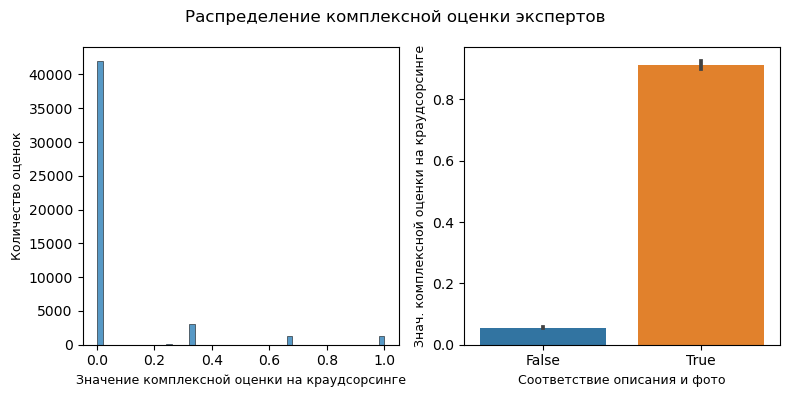

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
sns.histplot(data = crowd_annotations['pos_ratio'], bins = 50, ax = ax[0])
ax[0].set_xlabel('Значение комплексной оценки на краудсорсинге', fontsize = 9)
ax[0].set_ylabel('Количество оценок', fontsize = 9)
sns.barplot(data = crowd_annotations, x = 'accordance', y = 'pos_ratio', ax = ax[1])
ax[1].set_xlabel('Соответствие описания и фото', fontsize = 9)
ax[1].set_ylabel('Знач. комплексной оценки на краудсорсинге', fontsize = 9)
plt.suptitle('Распределение комплексной оценки экспертов', fontsize = 12)
plt.tight_layout()
plt.show()

Приятное открытие - "толпа" также хорошо размечает данные как и эксперты: оценки фотографиям с подходящими оценками значительно выше, чем тем, для которых описание уот других фото. Вероятно так получается, потому что в опросах принимают участие несколько (до 6) человек.

### Проектирование комплексной оценки

Посмотрим, сколько наивысших оценок в таблице с данными краудсориснга и аналогично для экспертых:

In [35]:
crowd_annotations.loc[crowd_annotations['pos_ratio'] == 1, 'pos_ratio'].count()

1323

In [36]:
expert_annotations.loc[expert_annotations['exp_ratio'] == 1, 'exp_ratio'].count()

247

Вместе 1570 - это больше, чем фото с собственным описание, значит, часто получается так, что описание было составлено не для рассматриваемой фотографии, но также подходит к нему (возможно описание носит обощенный характер). Сольем все таблицы, за основу возьмем таблицу с оценками толпы (она больше):

In [37]:
train_result_df = crowd_annotations.merge(expert_annotations[['image', 'query_id', 'exp_ratio']], how = 'outer', on = ['image', 'query_id'])
train_result_df = train_result_df.rename(columns = {'pos_ratio' : 'crowd_ratio'})
display(train_result_df.head())
print(train_result_df.shape)

image                     query_id  crowd_ratio  pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0  3.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0  0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0  0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0  0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0  0.0   

   neg accordance  crowd_cnt  exp_ratio  
0  0.0       True        3.0        NaN  
1  3.0      False        3.0        NaN  
2  3.0      False        3.0        NaN  
3  3.0      False        3.0        NaN  
4  3.0      False        3.0        NaN

(51323, 8)


In [38]:
train_result_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51323 non-null  object 
 1   query_id     51323 non-null  object 
 2   crowd_ratio  47830 non-null  float64
 3   pos          47830 non-null  float64
 4   neg          47830 non-null  float64
 5   accordance   47830 non-null  object 
 6   crowd_cnt    47830 non-null  float64
 7   exp_ratio    5822 non-null   float64
dtypes: float64(5), object(3)
memory usage: 3.5+ MB


In [39]:
train_result_df = (train_result_df
                   .merge(train_dataset[['query_id', 'query_text']].drop_duplicates(),
                                           how = 'inner',
                                           on = 'query_id')
                   .drop(columns = ['pos', 'neg', 'accordance', 'query_id'])
                  )
train_result_df = train_result_df[['image', 'query_text', 'crowd_ratio', 'crowd_cnt', 'exp_ratio']]
display(train_result_df.head())
print(train_result_df.shape)

image  \
0  1056338697_4f7d7ce270.jpg   
1  2182488373_df73c7cc09.jpg   
2  2594042571_2e4666507e.jpg   
3  2843695880_eeea6c67db.jpg   
4  2892995070_39f3c9a56e.jpg   

                                          query_text  crowd_ratio  crowd_cnt  \
0  A woman is signaling is to traffic , as seen f...          1.0        3.0   
1  A woman is signaling is to traffic , as seen f...          0.0        3.0   
2  A woman is signaling is to traffic , as seen f...          0.0        3.0   
3  A woman is signaling is to traffic , as seen f...          0.0        3.0   
4  A woman is signaling is to traffic , as seen f...          0.0        3.0   

   exp_ratio  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

(50214, 5)


In [40]:
print(train_result_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 50213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50214 non-null  object 
 1   query_text   50214 non-null  object 
 2   crowd_ratio  46721 non-null  float64
 3   crowd_cnt    46721 non-null  float64
 4   exp_ratio    5822 non-null   float64
dtypes: float64(3), object(2)
memory usage: 2.3+ MB
None


Все пропуски с оценками заполним нулями (их нет), а также создадим колонку с количеством экспертов, мы знаем, что их всегда 3, но для расчета комплексной оценки - сделаем:

In [41]:
train_result_df['exp_cnt'] = train_result_df['exp_ratio'].notna().astype('int')*3
train_result_df.fillna(0, inplace = True)

Теперь рассчитаем сводную оценку экспертов и толпы, несмотря на то, что краудсорсеры также хорошо оценивают описания, как и эксперты, думаю будет опрадано увеличить вес экспертных оценок до 2. Формулу примем следующую:

$$\frac{W_e*R_e*C_e + R_c*C_c}{W_e*C_e - C_c}$$
Обозначения: $W_e$ - вес экспертных оценок (примем равынм 2), $R_e$ - сводная оценка экспертов в диапазоне от 0 до 1, $C_e$ - количество экспертов, задействованых для оценки (всегда равно 3), $R_c$ - сводная оценка "толпы", $C_c$ - количество человек, задействованых для оценки (от 3 до 6).

В результате применения такой формулы сводная оценка будет также в диапазоне от 0 до 1 и при этом не будет занижаться, если эксперты или "толпа" не оценивали пару (как в случае с обычным усреднением или иным взятием в пропорции). Применим формулу:

In [42]:
EXP_WEIGHT = 2
def complex_estimation(row):
    return (EXP_WEIGHT*row['exp_ratio']*row['exp_cnt'] + row['crowd_ratio']*row['crowd_cnt']) / (EXP_WEIGHT*row['exp_cnt'] + row['crowd_cnt'])
train_result_df['complex_est'] = train_result_df.apply(complex_estimation , axis = 1)
display(train_result_df.head())

image  \
0  1056338697_4f7d7ce270.jpg   
1  2182488373_df73c7cc09.jpg   
2  2594042571_2e4666507e.jpg   
3  2843695880_eeea6c67db.jpg   
4  2892995070_39f3c9a56e.jpg   

                                          query_text  crowd_ratio  crowd_cnt  \
0  A woman is signaling is to traffic , as seen f...          1.0        3.0   
1  A woman is signaling is to traffic , as seen f...          0.0        3.0   
2  A woman is signaling is to traffic , as seen f...          0.0        3.0   
3  A woman is signaling is to traffic , as seen f...          0.0        3.0   
4  A woman is signaling is to traffic , as seen f...          0.0        3.0   

   exp_ratio  exp_cnt  complex_est  
0        0.0        0          1.0  
1        0.0        0          0.0  
2        0.0        0          0.0  
3        0.0        0          0.0  
4        0.0        0          0.0

In [43]:
train_result_df.drop(columns = ['crowd_ratio', 'crowd_cnt', 'exp_ratio', 'exp_cnt'], inplace = True)
print(train_result_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 50213
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50214 non-null  object 
 1   query_text   50214 non-null  object 
 2   complex_est  50214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB
None


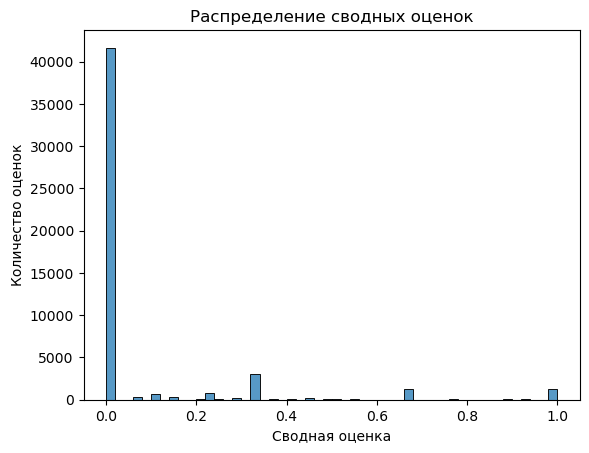

In [44]:
sns.histplot(data = train_result_df['complex_est'], bins = 50)
plt.xlabel('Сводная оценка')
plt.ylabel('Количество оценок')
plt.title('Распределение сводных оценок')
plt.show()

Распределение комплексной оценки больше похоже на распределоение оценок "толпы", т.к. данных по их оценкам у нас больше.

**Выводы:**
1. Всего 158 фотографий в тренировочном наборе имеют описание, которое составлено непосредственно для них;
1. Мы исследовали, насколько качественно размечают данные эксперты и "толпа" (краудсорсинг) и пришли к выводу, что оба варианта оценки в целом качественно размечают данные;
1. Фотографиям с подходящим описанием эксперты в более чем 75% случаев ставят высшую оценку - 4, а тем, которым сопоставлено описание от других фотографий эксперты чаще ставят низшую оценку - 1 и только в 75% случаев - 2 и выше (иногда 4);
1. В опросах краудсорсинга участвуют от 3 до 6 человек - это хорошо, т.к. увеличивает шансы на объективность оценки;
1. Оценки экспертов были приведены к единой оценке с диапазоном от 0 до 1 и далее объединены с оценками "толпы" в комплексную оценку.

## Исключение запрещенного контента

Согласно условий для проекта, на наше ПО распространяются ограничения по обработке изображений детей (ребёнком считается любой человек, не достигший 16-ти лет). При попытке посмотреть изображения, запрещённые законодательством, вместо картинок должен показывается дисклеймер: **This image is unavailable in your country in compliance with local laws**. Необходимо очистить обучающие данные от проблемного контента, а во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

Далее, создадим функцию **child_protect**, которая будет лемматизировать запрос и искать слова из специально составленного списка **stop_words** прямо или косвенно связанные с детьми и возвращать **True** в случае их обнаружения, а в противном случае **False**:

In [45]:
words = re.compile(r'[^a-zA-Z]+')
lemmatizer = WordNetLemmatizer()

def nlp_preprocessing(text):

    global lemmatizer

    text = text.lower()
    text = re.sub(r"´", "'", text) # иногда вместо одинарной кавычки ' используется ´
    text = re.sub(words, ' ', text) # оставляем только слова
    text = re.sub('\s+', ' ', text) # удалим лишние пробелы между словами
    text = text.strip(' ') # удалим лишние пробелы в конце и начале строки

    tagged_words = nltk.pos_tag(word_tokenize(text)) # разделим текст на отдельные слова и их POS-теги
    wn_tags = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ} # для преобразования POS-тегов в формат WordNet

    # приведем формы слов к начальным (лемматизируем) с учетом POS-тега
    lemmatized_words = []
    for word, tag in tagged_words:
        if tag[0] in wn_tags:
            lemma = lemmatizer.lemmatize(word, wn_tags[tag[0]])
        else:
            lemma = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemma)

    text = ' '.join(lemmatized_words)
    return text

In [46]:
stop_words = [
    "boy",
    "girl",
    "child",
    "baby",
    "kid",
    "babe",
    "infant",
    "teenager",
    "teeny",
    "juvenile",
    "teener",
    "stripling",
    "young",
    "toddler"]

childs = re.compile(r'|'.join(stop_words))

def child_protect(text):
    text_lemm = nlp_preprocessing(text)
    return False if re.search(childs, text_lemm) == None else True

In [47]:
# проверим работу функции:
train_result_df['query_prohibited'] = train_result_df['query_text'].apply(child_protect)
display(train_result_df[['query_text', 'query_prohibited']].sample(n = 10, random_state = RANDOM_SEED))

query_text  query_prohibited
27068    A golden dog looks alert as he stands in snow .             False
12790  Black dog jumping over a white dog in a snowy ...             False
34086     A little girl jumps rope through a parking lot              True
4296                Two toddlers posing for the camera .              True
41377  Several people on top of a mountain look down ...             False
21132  A brown dog leaps into the air next to a black...             False
44058  Two men in a fishing boat on a river enjoy a p...             False
42247  Group of children in blue uniforms sitting on ...              True
41460  A homeless man stands with a sign next to oran...             False
5585                     A woman riding a bike in a park             False

Теперь нам необходимо очистить тренировочный набор данных от фото с детьми, для этого найдем все пары **фото:описание**, где в описании упоминается ребенок и при этом косплексная оценка соответствия описания к фото больше 0.5, что можно вербально интерпретировать как "скорее да, чем нет":

In [48]:
# найдем все фото с детьми:
child_images = set(train_result_df.loc[(train_result_df['query_prohibited'] == True) & (train_result_df['complex_est'] > 0.5), 'image'])
print(len(child_images))

305


In [49]:
train_result_df['image_prohibited'] = train_result_df['image'].isin(child_images)
train_result_df.head()

image  \
0  1056338697_4f7d7ce270.jpg   
1  2182488373_df73c7cc09.jpg   
2  2594042571_2e4666507e.jpg   
3  2843695880_eeea6c67db.jpg   
4  2892995070_39f3c9a56e.jpg   

                                          query_text  complex_est  \
0  A woman is signaling is to traffic , as seen f...          1.0   
1  A woman is signaling is to traffic , as seen f...          0.0   
2  A woman is signaling is to traffic , as seen f...          0.0   
3  A woman is signaling is to traffic , as seen f...          0.0   
4  A woman is signaling is to traffic , as seen f...          0.0   

   query_prohibited  image_prohibited  
0             False             False  
1             False             False  
2             False              True  
3             False             False  
4             False             False

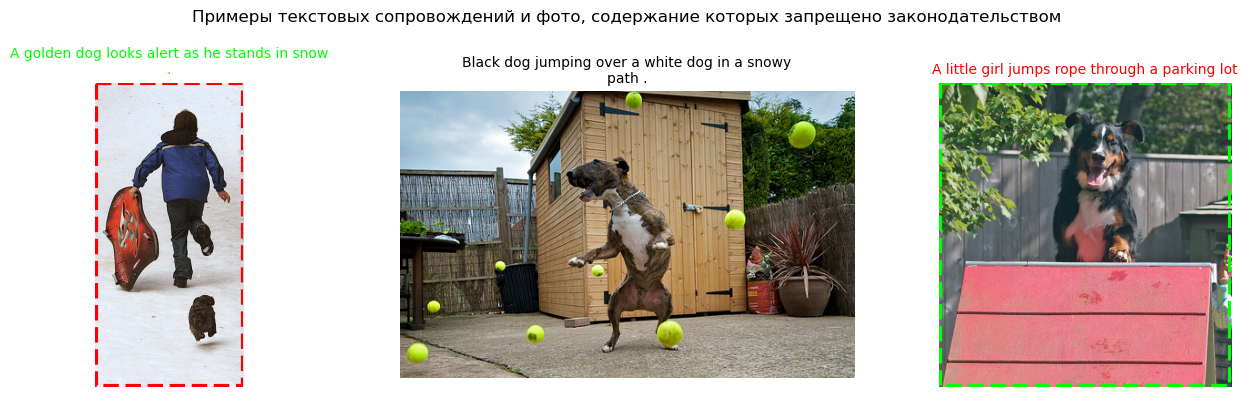

In [50]:
# проверим работу функции:
rows = 1
columns = 3

fig = plt.figure(figsize=(14, 4))
count = 1
for idx, file, query_text in train_result_df[['image', 'query_text']].sample(rows * columns, random_state = RANDOM_SEED).itertuples():
    ax = fig.add_subplot(rows, columns, count)
    count += 1

    img = mpimg.imread(TRAIN_IMG_DIR + file)
    ax.imshow(np.array(img))

    height, width, channels = img.shape
    chunks, chunk_size = query_text.split(), 10

    # Создание прямоугольника-рамки для всего графика
    if train_result_df.iloc[idx].query_prohibited or train_result_df.iloc[idx].image_prohibited:
        if train_result_df.iloc[idx].image_prohibited:
            rect = patches.Rectangle((2, 1), width-4, height-3, linewidth = 3, edgecolor='r', facecolor='none', ls = '--')
        else:
            rect = patches.Rectangle((2, 1), width-4, height-3, linewidth = 3, edgecolor='lime', facecolor='none', ls = '--')
        ax.add_patch(rect)
        if train_result_df.iloc[idx].query_prohibited:
            plt.title('\n'.join([' '.join(chunks[i : i + chunk_size]) for i in range(0, len(chunks), chunk_size)]),
                      fontdict = {'fontsize': 10, 'color' : 'r'})
        else:
            plt.title('\n'.join([' '.join(chunks[i : i + chunk_size]) for i in range(0, len(chunks), chunk_size)]),
                      fontdict = {'fontsize': 10, 'color' : 'lime'})
    else:
        plt.title('\n'.join([' '.join(chunks[i : i + chunk_size]) for i in range(0, len(chunks), chunk_size)]),
                  fontdict = {'fontsize': 10, 'color' : 'black'})


    plt.axis('off')

plt.suptitle('Примеры текстовых сопровождений и фото, содержание которых запрещено законодательством', fontsize = 12)
plt.tight_layout()
plt.show()

Фото и описание черного цвета говорят о том, что они никак не связаны с детьми. Если описание красное, то такой запрос будет отклоняться системой, а если фото обведено красным, то на нем изображен ребенок. При этом важно обратить внимание: в левом верхнем углу, изображен ребенок, но описание не содержит его упоминания. Такая пара будет также удалена из обучающего набора:

In [51]:
idx_prohibited = train_result_df.loc[(train_result_df['query_prohibited'] == True) | (train_result_df['image_prohibited'] == True)].index
print(f'Всего объектов, которые необходимо удалить из набора: {len(idx_prohibited)}')

Всего объектов, которые необходимо удалить из набора: 23119


In [52]:
train_result_df = train_result_df.drop(index = idx_prohibited).reset_index(drop = True).drop(columns = ['query_prohibited', 'image_prohibited'])
print(f'Размеры датасета после предобработки: {train_result_df.shape}')

Размеры датасета после предобработки: (27095, 3)


In [53]:
# выведем несколько строк полученного датасета:
train_result_df.head()

image  \
0  1056338697_4f7d7ce270.jpg   
1  2182488373_df73c7cc09.jpg   
2  2843695880_eeea6c67db.jpg   
3  2892995070_39f3c9a56e.jpg   
4  2934359101_cdf57442dc.jpg   

                                          query_text  complex_est  
0  A woman is signaling is to traffic , as seen f...          1.0  
1  A woman is signaling is to traffic , as seen f...          0.0  
2  A woman is signaling is to traffic , as seen f...          0.0  
3  A woman is signaling is to traffic , as seen f...          0.0  
4  A woman is signaling is to traffic , as seen f...          0.0

## Векторизация исходных данных

### Векторизация текста с помощью BERT

Для векторизации текстового описания будем использовать базовую версию BERT.

План работы:
1. Загрузка предобученной модели BERT и токенизатора;
1. Токенизация текста в номера токенов из словаря методом encode();
1. Приведение векторов к одному размеру путем прибавления к более коротким векторам идентификатора 0 (padding);
1. Создание маски внимания (attention_mask), которая указывает, что прибавленные 0 не несут информации;
1. Подготовка эмбеддингов.

Для моделей BERT не требуется предварительная обработка текста, т.к. там есть свой токенизатор, который сразу переводит текст в понятные модели теги, поэтому будем подавать в BERT "сырой" текст:

In [54]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

tokenizer_BERT = tokenizer_class.from_pretrained(pretrained_weights)
model_BERT = model_class.from_pretrained(pretrained_weights)

# переместим модель на GPU:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BERT = model_BERT.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [55]:
# выделим только уникальные запросы:
doc = train_result_df['query_text'].drop_duplicates().reset_index(drop = True).astype('string')
display(doc.head())
print(f'\nКоличество уникальных запросов: {doc.shape[0]}')

0    A woman is signaling is to traffic , as seen f...
1    A woman wearing black clothes , a purple scarf...
2    An older woman with blond hair rides a bicycle...
3    A woman wearing a white glove peers over the c...
4        A man taking a picture with a silver camera .
Name: query_text, dtype: string


Количество уникальных запросов: 671


In [56]:
%%time
file_name = OUTPUT_DIR + 'text_embeddings.pkl'
if not os.path.isfile(file_name) or RECNT_NBOOK:
    # загрузим предобученную модель и токенизатор DistilBERT:
    #model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

    # если необходимо использовать BERT вместо DistilBERT, нужно раскомментировать следующую строку:
    model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

    tokenizer_BERT = tokenizer_class.from_pretrained(pretrained_weights)
    model_BERT = model_class.from_pretrained(pretrained_weights)

    # переместим модель на GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_BERT = model_BERT.to(device)
    print('Устройство:', device)

    # токенизируем тексты:
    # укажем аргумент add_special_tokens = True, чтобы к тексту добавлялся токен начала (101) и токен конца текста (102)
    # укажем аргумент truncation = True, чтобы тексты длиннее 512 токенов обрезались (ограничение модели BERT)
    tokenized = doc.progress_apply(lambda x: tokenizer_BERT.encode(x, truncation=True, add_special_tokens=True))

    # найдём максимальную длину векторов после токенизации:
    max_len = max(len(sublist) for sublist in tokenized.values)
    print(f'Максимальная длина векторов после токенизации: {max_len}')

    # приведем вектора к одному размеру:
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

    # создадим маску для важных токенов:
    attention_mask = np.where(padded != 0, 1, 0)

    # эмбеддинги будем создавать батчами, чтобы хватило памяти:
    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
        lower_edge = batch_size*i
        upper_edge = batch_size*(i+1) if batch_size*(i+1) < padded.shape[0] else padded.shape[0]
        # преобразуем данные в формат тензоров:
        batch = torch.LongTensor(padded[lower_edge:upper_edge])
        attention_mask_batch = torch.LongTensor(attention_mask[lower_edge:upper_edge])

        # переместим входные данные на GPU:
        batch = batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)

        # для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны, модель BERT обучать не будем:
        with torch.no_grad():
            batch_embeddings = model_BERT(batch, attention_mask = attention_mask_batch)

        # из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов,
        # перенесем данные с GPU методом cpu() и преобразуем элементы методом numpy() к типу numpy.array:
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        joblib.dump(embeddings, file_name)
else:
    embeddings = joblib.load(file_name)
embeddings = np.concatenate(embeddings)
embeddings.shape

CPU times: user 3.38 ms, sys: 2.97 ms, total: 6.35 ms
Wall time: 6.43 ms


(671, 768)

In [57]:
doc = pd.DataFrame(doc)
doc['query_vector'] = embeddings.tolist()
doc['query_vector'] = doc['query_vector'].apply(lambda x: tf.convert_to_tensor([x], dtype=np.float64))
display(doc.head())
print(f'\nРазмер вектора описания картинки: {doc.loc[0, "query_vector"].shape[1]}')

query_text  \
0  A woman is signaling is to traffic , as seen f...   
1  A woman wearing black clothes , a purple scarf...   
2  An older woman with blond hair rides a bicycle...   
3  A woman wearing a white glove peers over the c...   
4      A man taking a picture with a silver camera .   

                                        query_vector  
0  ((tf.Tensor(0.04384385794401169, shape=(), dty...  
1  ((tf.Tensor(0.27778658270835876, shape=(), dty...  
2  ((tf.Tensor(0.3754226863384247, shape=(), dtyp...  
3  ((tf.Tensor(0.35252082347869873, shape=(), dty...  
4  ((tf.Tensor(-0.2991872727870941, shape=(), dty...


Размер вектора описания картинки: 768


### Векторизация изображений с помощью ResNet50

Для векторизации изображение будем использовать нейронную сеть ResNet50, предобученную на **imagenet**. Мы не будем ее переобучать и не будем задавать выходной слой, чтобы забрать только эмбеддинги:

In [58]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape, include_top = False, weights='imagenet')
    backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D(trainable = False))
    model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

    return model

In [59]:
def image_to_array(file: str, path: str = TRAIN_IMG_DIR, wh: int = 224, ht: int = 224):
    img = image.load_img(path + file, target_size=(wh, ht))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [60]:
model = create_model((224, 224, 3))

In [61]:
# выделим только уникальные изображения:
image_vec = pd.DataFrame(train_result_df['image'].drop_duplicates().reset_index(drop = True))
display(image_vec.head())
print(f'\nКоличество уникальных изображений: {image_vec.shape[0]}')

image
0  1056338697_4f7d7ce270.jpg
1  2182488373_df73c7cc09.jpg
2  2843695880_eeea6c67db.jpg
3  2892995070_39f3c9a56e.jpg
4  2934359101_cdf57442dc.jpg


Количество уникальных изображений: 695


In [62]:
%%time
file_name = OUTPUT_DIR + 'img_embeddings.pkl'
if not os.path.isfile(file_name) or RECNT_NBOOK:
    img_embeddings = image_vec.apply(lambda x: tf.cast(model(image_to_array(x['image'])), dtype=np.float64), axis=1)
    joblib.dump(img_embeddings, file_name)
else:
    img_embeddings = joblib.load(file_name)
image_vec['image_vector'] = img_embeddings

CPU times: user 220 ms, sys: 16 ms, total: 236 ms
Wall time: 236 ms


In [63]:
display(image_vec.head())
print(f'\nРазмер вектора изображения: {image_vec.loc[0, "image_vector"].shape[1]}')

image  \
0  1056338697_4f7d7ce270.jpg   
1  2182488373_df73c7cc09.jpg   
2  2843695880_eeea6c67db.jpg   
3  2892995070_39f3c9a56e.jpg   
4  2934359101_cdf57442dc.jpg   

                                        image_vector  
0  ((tf.Tensor(0.0865662693977356, shape=(), dtyp...  
1  ((tf.Tensor(0.8108564019203186, shape=(), dtyp...  
2  ((tf.Tensor(0.8698896169662476, shape=(), dtyp...  
3  ((tf.Tensor(0.001278685056604445, shape=(), dt...  
4  ((tf.Tensor(0.3441818654537201, shape=(), dtyp...


Размер вектора изображения: 2048


**Выводы**

Для работы будущей модели поиска изображений по текстовому запросу исходные данные были векторизованы следущим способом:
* текстовые запросы из тренировочного набора с помощью стандартной модели BERT, размер эмбеддинга на выходе - 768;
* изображения из тренировочного набора с помощью сверточной нейронной сети ResNet50, размер эмбеддинга на выходе - 2048.

## Подготовка данных для обучения

В данном разделе отберем данные для обучения и разделим их на тренировочную и валидационную выборки. Примем следующую логику работы для будущей модели поиска изображений по текстовому запросу:
* на вход модель получает векторизованный эмбеддинг текстового запроса с размерностью 768;
* переводит его в некоторое приближенное подобие векторизованного эмбеддинга изображения, которое такому запросу должно соответствовать, с размерностью 2048.

Чтобы научить модель выполнять такие вычисления (преобразования), мы должны отобрать пары описание-изображение, в которых изображение полностью или частично подходит описанию. Сделаем это, опираясь на комплексную оценку - если оценка выше 0.5, значит описание больше подходит, чем нет.

**Примечание:** отбор по комплексной оценке нельзя считать некоторым упрощением задачи, т.к. для проверки работы модели мы будем искать соответствие одному текстовому запросу по всему набору, в котором большинство картинок ему не соответствует в силу объективных причин.

In [64]:
# объединим векторизованные эмбеддинги с общим набором данных:
train_vectorized_df = train_result_df.merge(doc, how = 'left', on = 'query_text')
train_vectorized_df = train_vectorized_df.merge(image_vec, how = 'left', on = 'image')
display(train_vectorized_df.head())
print(train_vectorized_df.info())

image  \
0  1056338697_4f7d7ce270.jpg   
1  2182488373_df73c7cc09.jpg   
2  2843695880_eeea6c67db.jpg   
3  2892995070_39f3c9a56e.jpg   
4  2934359101_cdf57442dc.jpg   

                                          query_text  complex_est  \
0  A woman is signaling is to traffic , as seen f...          1.0   
1  A woman is signaling is to traffic , as seen f...          0.0   
2  A woman is signaling is to traffic , as seen f...          0.0   
3  A woman is signaling is to traffic , as seen f...          0.0   
4  A woman is signaling is to traffic , as seen f...          0.0   

                                        query_vector  \
0  ((tf.Tensor(0.04384385794401169, shape=(), dty...   
1  ((tf.Tensor(0.04384385794401169, shape=(), dty...   
2  ((tf.Tensor(0.04384385794401169, shape=(), dty...   
3  ((tf.Tensor(0.04384385794401169, shape=(), dty...   
4  ((tf.Tensor(0.04384385794401169, shape=(), dty...   

                                        image_vector  
0  ((tf.Tensor(0.0865662693977356, shape=(), dtyp...  
1  ((tf.Tensor(0.8108564019203186, shape=(), dtyp...  
2  ((tf.Tensor(0.8698896169662476, shape=(), dtyp...  
3  ((tf.Tensor(0.001278685056604445, shape=(), dt...  
4  ((tf.Tensor(0.3441818654537201, shape=(), dtyp...

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27095 entries, 0 to 27094
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         27095 non-null  object 
 1   query_text    27095 non-null  object 
 2   complex_est   27095 non-null  float64
 3   query_vector  27095 non-null  object 
 4   image_vector  27095 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.2+ MB
None


In [65]:
accordance_idx = train_vectorized_df.loc[train_vectorized_df['complex_est'] > 0.5, 'image'].index
print(f'Итого изображений, степень совместимости с описанием у которых > 50%: {len(accordance_idx)}')

Итого изображений, степень совместимости с описанием у которых > 50%: 2011


Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для этого воспользуемся классом **GroupShuffleSplit** из библиотеки sklearn.model_selection:

In [66]:
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.75, random_state = RANDOM_SEED)
train_idx, valid_idx = next(
    gss.split(
        X = train_vectorized_df.loc[accordance_idx].drop(columns=['complex_est']),
        y = train_vectorized_df.loc[accordance_idx, 'complex_est'],
        groups = train_vectorized_df.loc[accordance_idx, 'image']))
train_df, valid_df = train_vectorized_df.loc[train_idx], train_vectorized_df.loc[valid_idx]
train_df.reset_index(drop = True, inplace = True)
valid_df.reset_index(drop = True, inplace = True)

In [67]:
# оставим для обучения только текст запроса, название изображений и их векторизованные сущности:
X_train = train_df[['query_text', 'query_vector']]
y_train = train_df[['image', 'image_vector']]

X_valid = valid_df[['query_text', 'query_vector']]
y_valid = valid_df[['image', 'image_vector']]

In [68]:
X = tf.stack(X_train['query_vector'])
Y = tf.stack(y_train['image_vector'])

X_val = tf.stack(X_valid['query_vector'])
Y_val = tf.stack(y_valid['image_vector'])

text_vector_size = X.shape[2]
image_vector_size = Y.shape[2]

print(f'Тренировочный набор данных: {X.shape, Y.shape}')
print(f'Валидационный набор данных: {X_val.shape, Y_val.shape}')

Тренировочный набор данных: (TensorShape([1514, 1, 768]), TensorShape([1514, 1, 2048]))
Валидационный набор данных: (TensorShape([497, 1, 768]), TensorShape([497, 1, 2048]))


Для будущей работы модели и ее проверки напишем несколько функций:

* get_text_embedding - служит для получения эмбеддинга с помощью BERT "на лету", так можно проверять поиск по любому запросу, даже тому, которого не было в исходных данных (единственное условие - запрос должен быть на английском языке);
* cosine_distance - вычисление косинусного рассотяния и его приведения к диапазону от 0 до 1, именно эту метрику будем использовать для опредления степени уверенности модели в выборе изображений;
* show_images - выводим найденные изображения;
* **search_image - основная функция, которая объединяет в себе весь процесс поиска и верификации изображений:** получает векторное представление текста, векторные представления изображений из базы, рассчитывает для каждой пары метрику на основе косинусного расстояния от 0 до 1, которая показывает, насколько текст и картинка подходят друг другу и отбирает lim лучших изображений, подходящих по строке запроса; для работы в нее необходимо передать предобученную модель.

In [69]:
def get_text_embedding(query_text):
    """Получение эмбеддинга текста с помощью BERT на лету из строки
    """
    global tokenizer_BERT, model_BERT

    tokenized = tokenizer_BERT.encode(query_text, truncation=True, add_special_tokens=True)
    tokenized = np.array([i for i in tokenized])
    attention_mask = np.where(tokenized != 0, 1, 0)

    tensor = torch.LongTensor(tokenized)
    attention_mask = torch.LongTensor(attention_mask)

    # переместим входные данные на GPU:
    tensor = tensor.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        embedding = model_BERT(tensor.unsqueeze(0), attention_mask = attention_mask.unsqueeze(0))

    embedding = embedding[0][:,0,:].cpu().numpy()
    embedding = tf.convert_to_tensor(embedding, dtype = np.double)

    return embedding

def cosine_distance(A: tf.Tensor, B: tf.Tensor):
    """Вычисление косинусного рассотяния и его приведение к диапазону от 0 до 1
    """
    A_float = tf.cast(A, dtype=np.float32)
    B_float = tf.cast(B, dtype=np.float32)
    cosine_similarity = (tf.reduce_sum(tf.multiply(A_float, B_float), axis = -1) / (tf.norm(A_float, axis = -1) * tf.norm(B_float, axis = -1))).numpy()
    cosine_distance = 1 - cosine_similarity # результат в диапазоне [0; 2], где 0 - максимальное сходство, а 2 - максимальное расстояние
    result = 1 - (cosine_distance / 2) # приводим к диапазону от 0 до 1 (в т.ч. "переворачиваем" его)

    return result

def show_images(query, images, *, path = TRAIN_IMG_DIR, suptitle = ''):
    columns = 4 if len(images) >= 4 else len(images)
    rows = math.ceil(len(images) / columns)
    fig = plt.figure(figsize=(3*columns, 3*rows))
    plt.suptitle(suptitle + query)
    count = 1
    for file, dist in images:
        img = Image.open(path + file)
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.title(round(dist, 3))
        plt.imshow(np.array(img))
        plt.axis('off')
    plt.tight_layout()
    #plt.show()
    return None

def search_image(query_text, images_base, lim, predict_func, *args, **kwargs):
    """Основная функция, которая объединяет в себе весь процесс поиска и верификации изображений ищет изображение по строке запроса,
    для работы в нее необходимо передать предобученную модель и аргументы для нее, в случае необходимости
    """
    # images_base с полями image, image_vector и (complex_est)
    query_lemm = nlp_preprocessing(query_text)
    # проверим нет ли юридических ограничений для запрашиваемого контента:
    if child_protect(query_lemm):
        print ('This image is unavailable in your country in compliance with local laws')
        return None

    # обработаем текст с помощью BERT:
    query_embedding = get_text_embedding(query_text)

    # получим представление вектора текста в виде вектора изображения, с помощью предсказания модели:
    query_image = predict_func(query_embedding, *args, **kwargs)

    # рассчитаем расстояния от полученного вектора до всех изображений в базе images_base
    distances = pd.Series(index = images_base.index, dtype = 'float64')
    for idx in images_base.drop_duplicates(subset = 'image').index:
        distances.loc[idx] = cosine_distance(query_image, images_base.loc[idx, 'image_vector'])

    best_match = distances.dropna().sort_values(ascending = False).iloc[:lim].index

    return [(images_base.loc[idx, 'image'], distances.loc[idx]) for idx in best_match]

## Обучение моделей для сопоставления текста и изображения

В данном разделе мы обучим две модели машинного обучения и нейронную сеть, которые должны будут сопоставлять текстовое описание и изображение, которое ему подходит. Для контроля обучения и сравнения результатов будем пользоваться метрикой MSE, т.к. зачастую нейронные сети с функцией потерь MSE обучаются быстрее:

### Linear Regressor

In [70]:
def fit_LR(X_tensor, y_tensor, model = LinearRegression()):
    return model.fit(tf.reshape(X_tensor, shape=(-1, X_tensor.shape[-1])), tf.reshape(y_tensor, shape=(-1, y_tensor.shape[-1])))

def predict_LR(X_tensor, model):
    y_pred = model.predict(tf.reshape(X_tensor, shape=(-1, X_tensor.shape[-1])))
    return tf.convert_to_tensor(y_pred)

def mse_LR(y_pred, y_true):
    return mean_squared_error(tf.reshape(y_pred, shape=(-1, y_pred.shape[-1])), tf.reshape(y_true, shape=(-1, y_true.shape[-1])))

In [71]:
lr = fit_LR(X, Y, LinearRegression())
y_pred = predict_LR(X_val, lr)
print(f'MSE модели линейная регрессия на валидационной выборке: {mse_LR(y_pred, Y_val)}')

MSE модели линейная регрессия на валидационной выборке: 0.6018010015575955


Очень неплохой результат для такой простой модели, проверим её способности на двух примерах из валидационного набора.

**Примечание**: в скобках над каждым изображением указана цифра от 0 до 1, которая показывает вероятность соответствия изображения тексту.

Looking for pictures under the description: A person is standing on skis in the snow with a dog


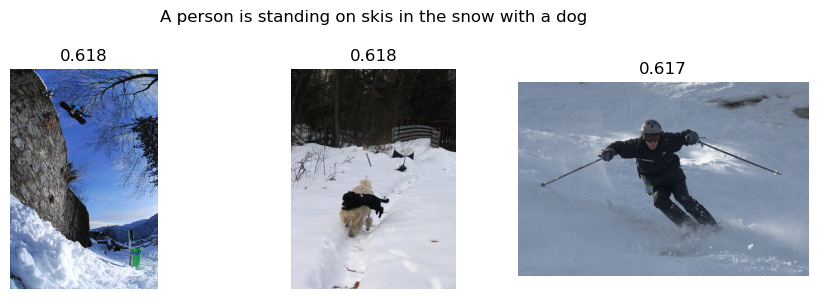

In [72]:
# query_text = random.choice(X_valid['query_text'])
query_text = 'A person is standing on skis in the snow with a dog'
print(f'Looking for pictures under the description: {query_text}')
images = search_image(query_text, y_valid, 3, predict_LR, lr)
if images:
    show_images(query_text, images)

Можно сказать, что попадание хорошие: люди на лыжах и собака - есть.

### Ridge Regressor

Проверим как себя покажет второй представитель семейства линейных моделей - Ridge Regressor и также проверим его поисковые способности на таких же запросах:

In [73]:
ridge = fit_LR(X, Y, Ridge())
y_pred = predict_LR(X_val, ridge)
print(f'MSE модели Ridge на валидационной выборке: {mse_LR(y_pred, Y_val)}')

MSE модели Ridge на валидационной выборке: 0.582199539223698


Метрика чуть лучше, но в масштабах десятых долей единицы - это много! Проверим:

Looking for pictures under the description: A person is standing on skis in the snow with a dog


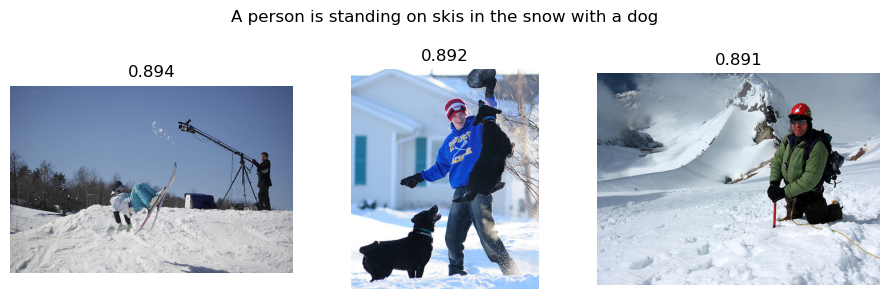

In [74]:
# query_text = random.choice(X_valid['query_text'])
query_text = 'A person is standing on skis in the snow with a dog'
print(f'Looking for pictures under the description: {query_text}')
images = search_image(query_text, y_valid, 3, predict_LR, ridge)
if images:
    show_images(query_text, images)

Кажется, что модель Ridge лучше замечает детали (практически на всех фото лыжи и люди, на одном есть собака) и ближе попадает предсказанием (уверенность выше, почти единица).

### Нейронная сеть

В рамках данного проекта я решил не углубляться в построение сложной нейронной сети, чтобы лишь продемонстрировать ее возможности и сравнить с линейными моделями. Посмотрим, что находится внутри подготовленных эмбеддиногов:

In [75]:
tensor_np = X.numpy()
min_value = np.min(tensor_np)
max_value = np.max(tensor_np)
print(f'Text vector range is ({min_value})-({max_value})')

tensor_np = Y.numpy()
min_value = np.min(tensor_np)
max_value = np.max(tensor_np)
print(f'Image vector range is ({min_value})-({max_value})')

Text vector range is (-8.62391471862793)-(4.130429744720459)
Image vector range is (0.0)-(26.618927001953125)


Видим, что на вход модели могут поступать отрицательные значения в векторе, значит первые слои должны быть способны их обрабатывать, следовательно распространненная функция активации ReLU не подойдёт, примем тангенциальную для первого слоя и leaky_relu для второго, чтобы мягко перевести значения меньше нуля в положительные.

Кроме того, для контроля переобучения добавим слои Dropout, а для воспроизводимости кода зафиксируем состояние random_state и инициализируем веса в слоях с помощью GlorotNormal (по результатам нескольких тестов показал себя лучше других):

In [76]:
def create_nn_model():
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

    optimizer = Adam()
    model = Sequential()
    model.add(Dense(text_vector_size,
                    activation='tanh',
                    kernel_initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_SEED)
                   ))
    model.add(Dropout(0.5))
    model.add(Dense(text_vector_size // 2,
                    activation='leaky_relu',
                    kernel_initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_SEED)
                   ))
    model.add(Dropout(0.5))
    model.add(Dense(text_vector_size // 4,
                    activation='relu',
                    kernel_initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_SEED)
                   ))
    model.add(Dense(image_vector_size // 2,
                    activation='relu',
                    kernel_initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_SEED)
                   ))
    model.add(Dropout(0.5))
    model.add(Dense(image_vector_size,
                    activation='relu',
                    kernel_initializer = tf.keras.initializers.GlorotNormal(seed = RANDOM_SEED)
                   ))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

    return model

In [77]:
%%time
nn_model = create_nn_model()
nn_model.fit(
    X, Y,
    #batch_size = 100,
    epochs = 100,
    validation_data = (X_val, Y_val),
    verbose = 1)

Epoch 1/100
48/48 [==============================] - 4s 48ms/step - loss: 0.6672 - mse: 0.6672 - val_loss: 0.6713 - val_mse: 0.6713
Epoch 2/100
48/48 [==============================] - 2s 38ms/step - loss: 0.6181 - mse: 0.6181 - val_loss: 0.6327 - val_mse: 0.6327
Epoch 3/100
48/48 [==============================] - 2s 39ms/step - loss: 0.6071 - mse: 0.6071 - val_loss: 0.5955 - val_mse: 0.5955
Epoch 4/100
48/48 [==============================] - 2s 37ms/step - loss: 0.6006 - mse: 0.6006 - val_loss: 0.6097 - val_mse: 0.6097
Epoch 5/100
48/48 [==============================] - 2s 38ms/step - loss: 0.5958 - mse: 0.5958 - val_loss: 0.5849 - val_mse: 0.5849
Epoch 6/100
48/48 [==============================] - 2s 37ms/step - loss: 0.5936 - mse: 0.5936 - val_loss: 0.5954 - val_mse: 0.5954
Epoch 7/100
48/48 [==============================] - 2s 36ms/step - loss: 0.5921 - mse: 0.5921 - val_loss: 0.5806 - val_mse: 0.5806
Epoch 8/100
48/48 [==============================] - 2s 37ms/step - loss: 0.

MSE чуть лучше, чем у линейных моделей, проверим на запросе, которым тестировали прошлые модели:

1/1 [==============================] - 0s 131ms/step


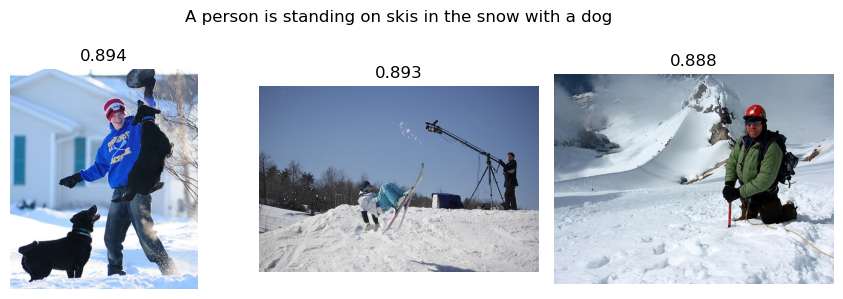

In [78]:
query_text = 'A person is standing on skis in the snow with a dog'

images = search_image(query_text, y_valid, 3, nn_model.predict)
show_images(query_text, images)

Также выведем несколько запросов и их результаты от всех обученных моделей для сравнения:

1/1 [==============================] - 0s 24ms/step


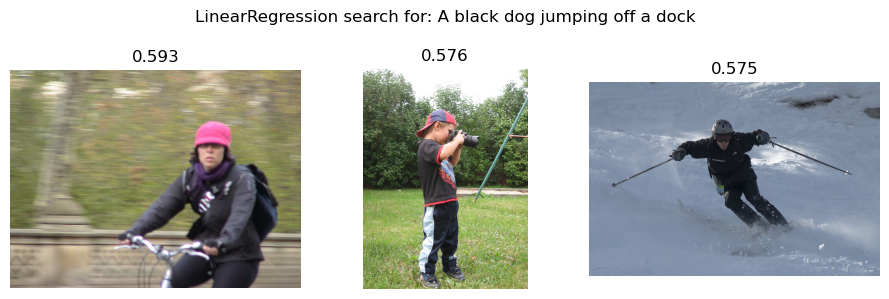

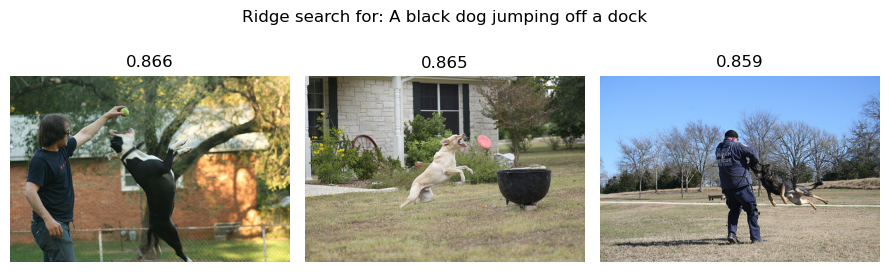

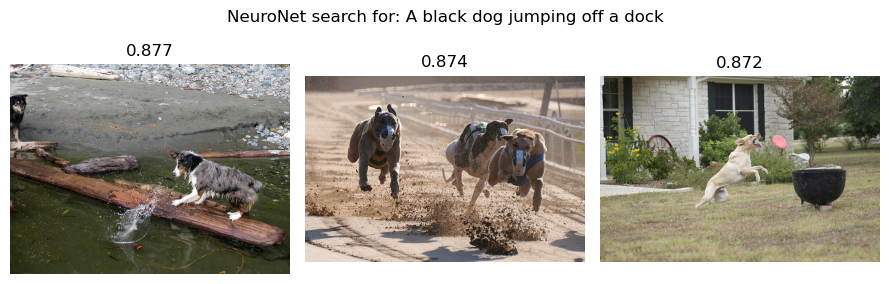

In [79]:
query_text = 'A black dog jumping off a dock'

images = search_image(query_text, y_valid, 3, predict_LR, lr)
show_images(query_text, images, suptitle = 'LinearRegression search for: ')

images = search_image(query_text, y_valid, 3, predict_LR, ridge)
show_images(query_text, images, suptitle = 'Ridge search for: ')

images = search_image(query_text, y_valid, 3, nn_model.predict)
show_images(query_text, images, suptitle = 'NeuroNet search for: ')

У нейронной сети лучше мэтчинг - собака практически на пристани (пусть и просто доска), на всех результатах у нейронной сети есть собаки, они везде в прыжке.

Тут в целом все справились хорошо, видимо триггером является снег и собака. Линейная регрессия даже нашла лыжи!

1/1 [==============================] - 0s 23ms/step


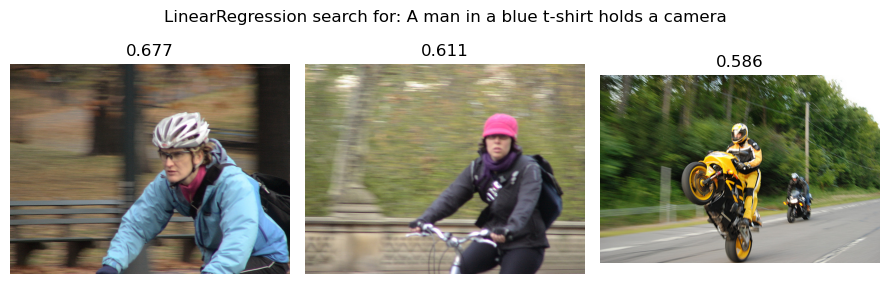

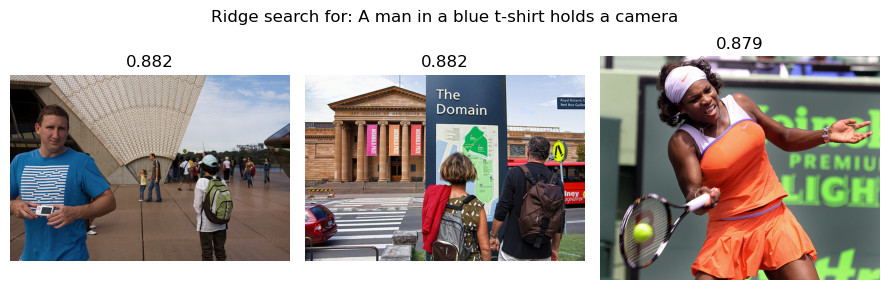

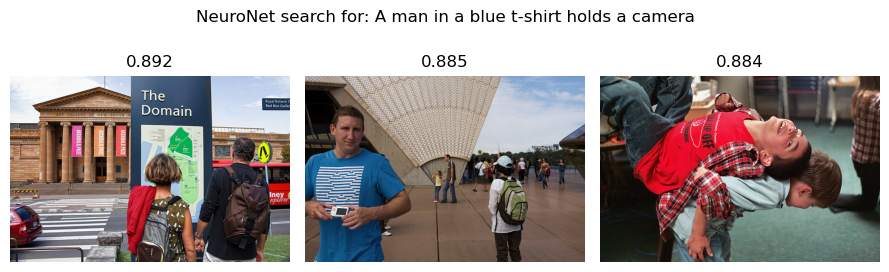

In [80]:
query_text = 'A man in a blue t-shirt holds a camera'

images = search_image(query_text, y_valid, 3, predict_LR, lr)
show_images(query_text, images, suptitle = 'LinearRegression search for: ')

images = search_image(query_text, y_valid, 3, predict_LR, ridge)
show_images(query_text, images, suptitle = 'Ridge search for: ')

images = search_image(query_text, y_valid, 3, nn_model.predict)
show_images(query_text, images, suptitle = 'NeuroNet search for: ')

В данном запросе лучший результат (визуально) показала Ridge, нейронная сеть тоже нашла мужчину в голубой футболке, но выдала его вторым результатом.

**Выводы**

* В данном разделе мы обучили две модели машинного обучения и нейронную сеть сопоставлять текстовое описание и изображение, которое ему подходит;
* Для контроля обучения и сравнения результатов биспользовали метрику MSE: лучший результат показала нейронная сеть;
* Для дополнительного контроля была проведена серия запросов и сравнение результатов всех трех моделей - по совокупности метрики и визуальной оценки нейронная сеть оказалась лучшей!

## Тестирование моделей

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки **test_images**, выберем 10 запросов из файла **test_queries** и для каждого запроса выведем несколько релевантных изображений. Сравним визуально качество поиска:

In [81]:
%%time
test_images['image_vector'] = test_images.apply(lambda x: tf.cast(model(image_to_array(x['image'], TEST_IMG_DIR)), dtype=np.float64),
                                                axis = 1)

CPU times: user 45.3 s, sys: 1.52 s, total: 46.8 s
Wall time: 28.6 s


Looking for pictures under the description: A woman wears a colorful shirt and a lot of jewelry.
1/1 [==============================] - 0s 23ms/step


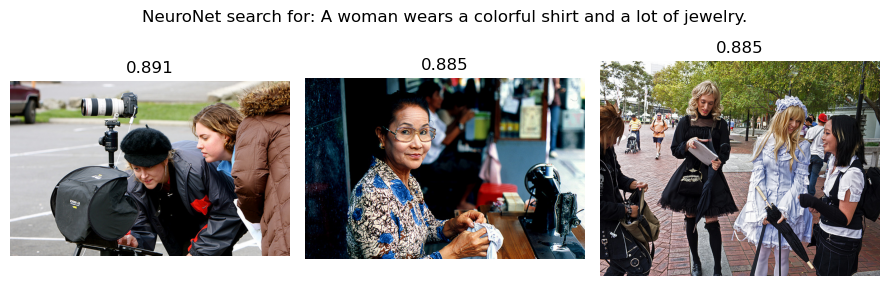

In [82]:
query_text = 'A woman wears a colorful shirt and a lot of jewelry.'
print(f'Looking for pictures under the description: {query_text}')

images = search_image(query_text, test_images, 3, nn_model.predict)
if images:
    show_images(query_text, images, path = TEST_IMG_DIR, suptitle = 'NeuroNet search for: ')

Looking for pictures under the description: A dog is catching a yellow tennis ball on the beach.
1/1 [==============================] - 0s 23ms/step


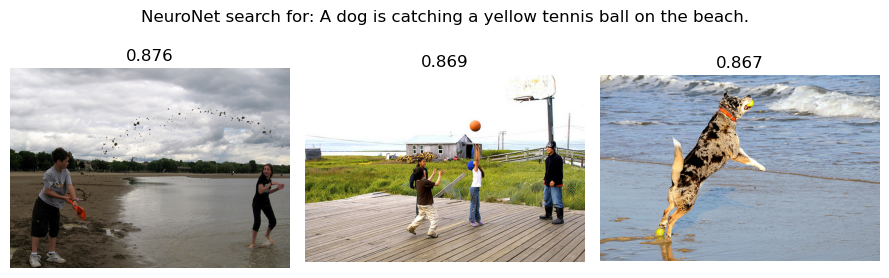

In [83]:
query_text = 'A dog is catching a yellow tennis ball on the beach.'
print(f'Looking for pictures under the description: {query_text}')

images = search_image(query_text, test_images, 3, nn_model.predict)
if images:
    show_images(query_text, images, path = TEST_IMG_DIR, suptitle = 'NeuroNet search for: ')

Также протестируем запрос, который содержит слово children:

In [84]:
query_text = 'A playground with two children and an adult'
print(f'Looking for pictures under the description: {query_text}')

images = search_image(query_text, test_images, 8, nn_model.predict)
if images:
    show_images(query_text, images, path = TEST_IMG_DIR, suptitle = 'NeuroNet search for: ')

Looking for pictures under the description: A playground with two children and an adult
This image is unavailable in your country in compliance with local laws


**Выводы**

По ощущениям на тесте нейронная сеть справляется хуже: очень хорошо находит людей, собак, крупные абстракции типа океан, лес, снег, но сложные абстракции её заводят в тупик. Вероятно это связано с маленьким датасетом - видимо еще не все запросы она в состоянии понять. Однако, в целом результаты неплохие и доказывают жизнеспособность идеи, задачу проекта можно считать выполненной. 

## Итоговые выводы

В данном проекте перед нами стояла задача разработать модель, которая по описанию сцены подбирает изображения. В качестве исходных данных были предоставлены: 1000 фотографий для обучения модели, 100 фотографий для тестирования и демонстрации возможностей модели, данные по соответствию изображения и описания, полученные с помощью краудсорсинга и в результате опроса экспертов.

Исходные данные были изучены и установлено:
* Данные не содержат пропусков, не содержат дубликатов;
* Предположительно описания одних фотографий могут также подходить и к другим и степень похожести могут определеить оценки полученные с помощью экспертов и краудсорсинга;
* Всего 158 фотографий в тренировочном наборе имеют описание, которое составлено непосредственно для них;
* Было установлено, что оба варианта оценки (экспертный и краудсорсинговый) в целом качественно размечают данные;
* Фотографиям с подходящим описанием эксперты в более чем 75% случаев ставят высшую оценку - 4, а тем, которым сопоставлено описание от других фотографий эксперты чаще ставят низшую оценку - 1 и только в 75% случаев - 2 и выше (иногда 4);
* В опросах краудсорсинга участвуют от 3 до 6 человек - это хорошо, т.к. увеличивает шансы на объективность оценки;
* Оценки экспертов были приведены к единой оценке с диапазоном от 0 до 1 и далее объединены с оценками "толпы" в комплексную оценку.

Согласно условий для проекта, на наше ПО распространяются ограничения по обработке изображений детей (ребёнком считается любой человек, не достигший 16-ти лет). Поэтому, при попытке посмотреть изображения, запрещённые законодательством, вместо картинок основная функция поиска показывает дисклеймер: **This image is unavailable in your country in compliance with local laws**.

Для работы будущей модели поиска изображений по текстовому запросу исходные данные были векторизованы следущим способом:
* текстовые запросы из тренировочного набора с помощью стандартной модели BERT, размер эмбеддинга на выходе - 768;
* изображения из тренировочного набора с помощью сверточной нейронной сети ResNet50, размер эмбеддинга на выходе - 2048.

Принята следующая логика работы для разработанной модели поиска изображений по текстовому запросу:
* на вход модель получает векторизованный эмбеддинг текстового запроса с размерностью 768;
* переводит его в некоторое приближенное подобие векторизованного эмбеддинга изображения, которое такому запросу должно соответствовать, с размерностью 2048.

Чтобы научить модель выполнять такие вычисления (преобразования), были отобраны пары описание-изображение, в которых изображение полностью или частично подходит описанию, опираясь на комплексную оценку - если оценка выше 0.5, значит описание больше подходит, чем нет.

Результатом проекта является **основная функция search_image, которая объединяет в себе весь процесс поиска и верификации изображений:** получает векторное представление текста, векторные представления изображений из базы, рассчитывает для каждой пары метрику на основе косинусного расстояния от 0 до 1, которая показывает, насколько текст и картинка подходят друг другу и отбирает lim лучших изображений, подходящих по строке запроса. Для ее работы необходима предобученная модель, на роль которой в рамках проекта были рассмотрены три варианты: LinearRegression, Ridge и нейронная сеть.

Все модели показали себя очень хорошо и по результатам подробного анализа для финального варианта была выбрана нейронная сеть.В целом, концепция показала свою жизнеспособность и может быть доработана с помощью увеличения датасета и построения более глубокой нейросети с более тщательным подбором гирперпараметров, возможно рассмотреть ансамбль моделей (нейронная сеть + Ridge), чтобы объединить их лучшие стороны.